# 3. Make orthology clusters
## 3.1 Run OrthoFinder
### 3.1.1 Set up paths

In [2]:
import misc, os

software_fpath = 'python OrthoFinderExe'

# I use a parallelized version by @sujaikumar which was not yet pulled
# to the master branch in OrthoFinder at the time of use
# https://github.com/davidemms/OrthoFinder/pull/17

misc.makedir('orthofinder')

# link files into the input direcotry
orth_base = './orthofinder'

lncline = "ln -s %s %s"

import misc, glob
# make an input subdirectory for the minimal dataset
misc.makedir('orthofinder/all_inputs')



# reference samples
my_samples = ['MareHarA','MincW1','MjavVW4', 'MfloSJF1', 'MentL30', 'MfloJB5']
prots_dir = "all_protein_ref_reviewed"
for s in my_samples:
    real_path = "%s/%s_ref.aa.fasta"%(prots_dir, s)
    ln_path   = '%s/all_inputs/%s_ref.aa.fasta'%(orth_base, s)
    
    if not os.path.exists(ln_path):
        misc.printoe(
            misc.execute_cline(lncline%(real_path, ln_path))
        )
        
# abad sample

#abad_fpath = "./GS978784/mi.protein.faa"
#ln_path   = "%s/all_inputs/mi.protein.faa"%orth_base

if not os.path.exists(ln_path):
    misc.printoe(
        misc.execute_cline(lncline%(abad_fpath, ln_path))
    )
# mapped samples
prots_dir = "./all_proteins"
for f in glob.glob(prots_dir+'/*.aa.fasta'):
    s = f.split('/')[-1].split('.')[0]
    real_path = "%s/%s.aa.fasta"%(prots_dir, s)
    ln_path   = '%s/all_inputs/%s.aa.fasta'%(orth_base, s)
    
    if not os.path.exists(ln_path):
        misc.printoe(
            misc.execute_cline(lncline%(real_path, ln_path))
        )

## Run orthofinder
# cline for minimal analysis
in_fpath = orth_base + '/all_inputs'

### 3.1.2 Iterate over inflation values

In [8]:
import os, misc
import pandas as pd


# first run, will do the blast step
orthofinder_exe = '%s/%i_orthofinder_parallel_beta_2bb1fe3.py'%(software_fpath, 1)
iter_cline = orthofinder_exe+" -f %s  -t 10"%in_fpath
misc.printoe(
    misc.execute_cline(iter_cline)
    )

import pandas as pd

inflation_to_use = 2 # this is an apostriori decision, based on table below 

# Subsequent runs, reuse blast results

results = []

for i in range(0,9) + [20]:
    # There are 9 copies of the orthofinder python script, numbered 0-8,20.
    # e.g., 2_orthofinder_parallel_beta_2bb1fe3.py.
    # The  numbers are also the mcl inflation value as set in the script
    # except for script 0, where the inflation value is the default (1.5)
    # and 1, where the inflation value is 1.1
    inflation_value = i
    if i == 1:
        inflation_value = 1.1
    elif i == 0:
        inflation_value = 1.5
    
    # iter_results collects statistics from this iteration,
    # which are shown in the output table
    iter_results = [inflation_value]
    
    # this is the executable for this specific iteration
    orthofinder_exe = '%s/%i_orthofinder_parallel_beta_2bb1fe3.py'%( 
                       software_fpath, i)
    
    # this is the command line for this specific iteration
    iter_cline = orthofinder_exe+" -b %s/%s/WorkingDirectory -t 15"%(
                                     in_fpath, 'Results_Jan16')
    
    # execute orthofinder
    #out, err = misc.execute_cline(iter_cline)
    
    # rename the ortofinder csv output file to indicate the executable that was used
    #os.rename('%s/%s/WorkingDirectory/OrthologousGroups.csv'%(in_fpath, 'Results_Jan16'),
    #          '%s/%s/%i_OrthologousGroups.csv'%(in_fpath, 'Results_Jan16',i))
    
    # analyse the csv file to prepare the table below
    
    # path to csv
    og_fpath = 'orthofinder/all_inputs/Results_Jan16/%i_OrthologousGroups.csv'%i
    
    #  read the csv to pandas dataframe
    OGs = pd.read_table(og_fpath, index_col=0)
    
    # these are OG categories I want to count in the CSV file
    one_to_ones = 0
    two_to_twos = 0
    between_one_and_four_in_all_samples = 0
    
    # The columns in the csv file (and in the dataframe)
    # are named with the protein input files of all the samples
    file_template = '%s_ref.aa.fasta'
    
    # I collect OGs I want to include in the phylogenetic analysis
    # from the orthofinder run with inflation value 2
    if inflation_value == inflation_to_use:
        OGs_to_get = []
    
    # count the OG categories and choose the ones to analyse
    for ind,row in OGs.iterrows():
        counts = {
            'MareHarA':0,
            'MincW1':0,
            'MjavVW4':0,
            'MfloSJF1':0,
            'MentL30':0
        }
        
        # in each column (ie, sample), the sequence IDs are seperated
        # with comas
        for sp in counts:
            try:
                counts[sp] = len(row[file_template%sp].split(','))
            except:
                counts[sp] = 0
                
        get = False
        
        if all([counts[sp] == 1 for sp in counts]):
            one_to_ones += 1
            get = True
        elif all([counts[sp] == 2 for sp in counts]):
            two_to_twos += 2
            get = True
        elif all([1 <= counts[sp] <= 4 for sp in counts]):
            between_one_and_four_in_all_samples += 1
            get = True

        if inflation_value == inflation_to_use and get:
            OGs_to_get.append(ind)
    
    iter_results.append(one_to_ones)
    iter_results.append(two_to_twos)
    iter_results.append(between_one_and_four_in_all_samples)
    results.append(iter_results)

# make the table
header = ['inflation',
          'one_to_ones'.replace('_',' '),
          'two_to_twos'.replace('_',' '),
          'between_one_and_four_in_all_samples'.replace('_',' ')]
   
df = pd.DataFrame(results, columns=header)
df

,inflation,one to ones,two to twos,between one and four in all samples
0,1.5,92,120,4840
1,1.1,27,96,2898
2,2.0,148,124,4675
3,3.0,182,98,4304
4,4.0,207,90,3981
5,5.0,205,74,3711
6,6.0,205,64,3491
7,7.0,214,58,3288
8,8.0,219,48,3136
9,20.0,221,22,2342


## 3.2 Merge inparalogues with phylogenetic analysis
### 3.2.1 Make a genbank file with inflation 2 groups

In [9]:
from collections import Counter
import pandas as pd
import misc, glob
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Alphabet import IUPAC

og_fpath = 'orthofinder/all_inputs/Results_Jan16/2_OrthologousGroups.csv'
gb_out = 'orthofinder/all_inputs/Results_Jan16/OGs_I2_1-4.gb'
refprotpath = './all_protein_ref_reviewed/%s_ref.aa.fasta'
refcdspath = './all_cds_ref_reviewed/%s_ref.cds.fasta'

sequences = {'MfloSJF1': {'aa': SeqIO.to_dict(SeqIO.parse(refprotpath%'MfloSJF1','fasta')),
                      'cds': SeqIO.to_dict(SeqIO.parse(refcdspath%'MfloSJF1','fasta'))},
             'MjavVW4': {'aa': SeqIO.to_dict(SeqIO.parse(refprotpath%'MjavVW4','fasta')),
                      'cds': SeqIO.to_dict(SeqIO.parse(refcdspath%'MjavVW4','fasta'))},
             'MincW1': {'aa': SeqIO.to_dict(SeqIO.parse(refprotpath%'MincW1','fasta')),
                      'cds': SeqIO.to_dict(SeqIO.parse(refcdspath%'MincW1','fasta'))},
             'MareHarA': {'aa': SeqIO.to_dict(SeqIO.parse(refprotpath%'MareHarA','fasta')),
                      'cds': SeqIO.to_dict(SeqIO.parse(refcdspath%'MareHarA','fasta'))},
             'MentL30': {'aa': SeqIO.to_dict(SeqIO.parse(refprotpath%'MentL30','fasta')),
                      'cds': SeqIO.to_dict(SeqIO.parse(refcdspath%'MentL30','fasta'))},
             'MfloJB5': {'aa': SeqIO.to_dict(SeqIO.parse(refprotpath%'MfloJB5','fasta')),
                      'cds': SeqIO.to_dict(SeqIO.parse(refcdspath%'MfloJB5','fasta'))},
            }

for f in glob.glob('all_cdss/*.cds.fasta'):
    smpl = f.split('/')[1].split('.')[0]
    protpath = './all_proteins/%s.aa.fasta'%smpl
    sequences[smpl] = {
        'aa': SeqIO.to_dict(SeqIO.parse(protpath,'fasta')),
        'cds': SeqIO.to_dict(SeqIO.parse(f,'fasta'))
    }

gb = open(gb_out,'wt')

OGs = pd.read_table(og_fpath, index_col=0)

filenames = [i.split('/')[-1] for i in glob.glob('./all_protein_ref_reviewed/*')]
filenames += [i.split('/')[-1] for i in glob.glob('./all_proteins/*')]


# write to genbank file
for ind,row in OGs.iterrows():
    if not ind in OGs_to_get:
        continue
            
    for f in filenames:    
        organism = f.split('_')[0].split('.')[0]
        try:
            ids = [x.strip().rstrip() for x in row[f].split(',')]

        except:
            continue
        for i in ids:
            cdsr = sequences[organism]['cds'][i]
                    
            num_ambig = len([p for p in str(cdsr.seq) if not p in 'atgcATGC'])
            if num_ambig > 9:
                continue
                
            if len(cdsr.seq) < 60:
                continue
                
            cdsr.seq.alphabet = IUPAC.ambiguous_dna
            protr = sequences[organism]['aa'][i]
            if str(protr.seq).count('x')+str(protr.seq).count('X')+str(protr.seq).count('*') > 3:
                continue
            source = SeqFeature(location=FeatureLocation(0, len(cdsr.seq)),
                                type='source',
                                qualifiers={'organism': [organism],
                                            'original_id': [cdsr.id]})
            
            cdsr.features.append(source)
            cds = SeqFeature(location=FeatureLocation(0, len(cdsr.seq)),
                             type='CDS',
                             qualifiers={'gene': [ind],
                                         'translation': [str(protr.seq).replace('*','X')]})
            cdsr.features.append(cds)
            cdsr.id = organism +'_'+ cdsr.id
            gb.write(cdsr.format('gb'))
    
gb.close()

### 3.2.2 Load the records into a reprophylo project

In [10]:
from reprophylodev import *

# If you did not generate OGs_I2_1-4.gb yourself and want to use the provided one
# you have to decompress it:
# !gzip -d orthofinder/all_inputs/Results_Jan16/OGs_I2_1-4.gb.gz

list_loci_in_genbank(gb_out,gb_out+'.loci.csv',gb_out+'.loci.txt')
pj = Project(gb_out+'.loci.csv', pickle=gb_out+'.pkpj', git=False)

gb_out

pj.read_embl_genbank([gb_out])

pj.extract_by_locus()

DEBUG:Cloud:Log file (/home/amir/.picloud/cloud.log) opened
reprophylodev.py:1015: UserWarning: Version control off
  warnings.warn('Version control off')


### 3.2.3 Distribution of copy numbers in each orthology cluster

1

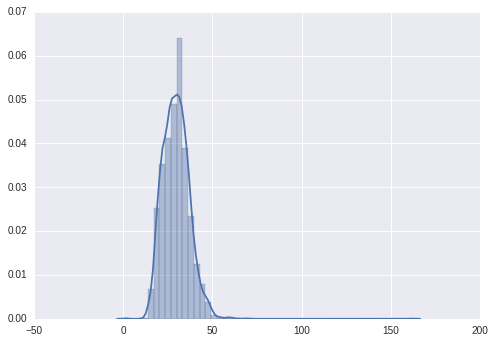

In [11]:
%matplotlib inline
#import matplotlib.pyplot as plt
import seaborn as sns
copy_counts = [len(pj.records_by_locus[i]) for i in pj.records_by_locus]

a=sns.distplot(copy_counts)#, bins=100)
min(copy_counts)

### 3.2.4 Prepare fasta input files
This will only write input fasta files for each orthology cluster

In [12]:
AlnConf(pj,
        loci = [l.name for l in pj.loci],
        method_name='linsiNoCDSAlign',
        program_name='mafft', 
        CDSAlign=False,  
        cline_args={'localpair':True, 'maxiterate': 1000})

These loci have less than 4 sequences and will be dropped from this conf object. Don't use them in a concatenation:
['OG0010039', 'OG0008617']


mafft --localpair --maxiterate 1000 207161484757013.97_OG0001798.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0004546.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0001790.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0001791.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0001792.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0001794.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0001795.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0001796.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0002229.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0002228.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0002225.fasta
mafft --localpair --maxiterate 1000 207161484757013.97_OG0002227.fasta
maf

<reprophylodev.AlnConf instance at 0x7fe0a82e95a8>

### 3.2.5 Save\ load the project

In [13]:
pickle_pj(pj, gb_out+'.pkpj')
# The pickled file is too large for github, but resulting fasta files are in there
# in the directory I2_rootknot_phylogenomics/raw

'orthofinder/all_inputs/Results_Jan16/OGs_I2_1-4.gb.pkpj'

In [ ]:
import pickle

gb_out = 'orthofinder/all_inputs/Results_Jan16/OGs_I2_1-4.gb'

with open(gb_out + '.pkpj', 'rb') as hndl:
    pj = pickle.load(hndl)

In [14]:
import glob
from misc import execute_cline

for f in glob.glob('orthofinder/all_inputs/Results_Jan16/rootknot_phylogenomics/raw/207161484757013.97_*.fasta'):
    out = f.replace('raw','non_cds_alignment').replace('.fasta','.aln.fasta')
    cline = 'mafft --thread 12 --localpair --maxiterate 1000 %s > %s' % (f,out)
    out, err = execute_cline(cline)

### 3.2.6 Run phylogenetic workflow on viper
The inputs and outputs of this are in the direcroty `I2_rootknot_phylogenomics` which was copied to and from the HPC.
#### 3.2.6.1 Python script for the HPC
  
Since viper only runs up to 1000 array jobs at a time, this needs to be run four times with the following values in the variable `sorted_OGs`, at the top of the python script for the HPC above:

`sorted_OGs = sorted(OGs)[0:]`  
`sorted_OGs = sorted(OGs)[1000:]`  
`sorted_OGs = sorted(OGs)[2000:]`  
`sorted_OGs = sorted(OGs)[3000:]`  

**Copy the rendered script and not the markdown source**  
  
**script starts here:**  

<pre>
from subprocess import Popen, PIPE
from warnings import warn
from sys import argv
import glob
from Bio import SeqIO

job = int(argv[1])-1
rp_id = argv[2]

inputs = list(glob.glob("/home/my_user/rootknot_phylogenomics/raw/*.fasta"))
print(len(inputs))
OGs = [i.rpartition('/')[-1].replace(rp_id+'_','').replace('.fasta','') for i in inputs]
sorted_OGs = sorted(OGs)[0:]
OG = sorted_OGs[job]

&#35; Run mafft
input_f = "/home/my_user/rootknot_phylogenomics/raw/{0}_{1}.fasta".format(rp_id, OG)
output_f = "/home/my_user/rootknot_phylogenomics/non_cds_alignment/{0}_{1}.aln.fasta".
format(rp_id, OG)

mafft = "mafft-7.299-with-extensions/core/mafft"
mafftcline = mafft + " --thread 28 --localpair --maxiterate 1000 {0} > {1}".format(input_f, output_f)

input_f = "/home/my_user/rootknot_phylogenomics/non_cds_alignment/{0}_{1}.aln.fasta".f
ormat(rp_id, OG)
output_f = "/home/my_user/rootknot_phylogenomics/non_cds_alignment-trimal0.7/{0}_{1}.a
ln.trm.fasta".format(rp_id, OG)

p = Popen(mafftcline, shell=True, stdout=PIPE, stderr=PIPE)
out, err = p.communicate()

print(out)
print(err)

&#35; Run trimal

trimal = "/home/my_user/trimAl/source/trimal"
trimalcline = trimal + " -in {0} -out {1} -gt 0.7 -st 0.001".format(input_f,output_f)

p = Popen(trimalcline, shell=True, stdout=PIPE, stderr=PIPE)
out, err = p.communicate()

print(out)
print(err)

&#35; Check filter out alignments in which a single gene copy is split between contigs

def is_bad_alignment(aln):
    badaln = False
    alnlength = aln.get_alignment_length()
    for i in range(len(aln)):
        if badaln:
            break
        iseqrecord = aln[i]
        isp = iseqrecord.id.split('_')[0]
        for j in range(i+1, len(aln)):
            jseqrecord = aln[j]
            jsp = jseqrecord.id.split('_')[0]
            if isp == jsp:
                overlap = 0
                for x in range(alnlength):
                    if aln[i,x] != '-' and aln[j,x] != '-':
                        overlap += 1
                if overlap &lt; 20:  
                    badaln = True
                    break
    return badaln
    
    
def check_alignment_file(f):
    
    from Bio import AlignIO
    aln = AlignIO.read(f,'fasta')
    aln_name = f.split('/')[-1].split('_')[0]
    if is_bad_alignment(aln):
        return aln_name
    else:
        return None
        
for f in glob.glob("/home/my_user/rootknot_phylogenomics/non_cds_alignment-trimal0.7/*_*.aln.fasta"):
    a = check_alignment_file(f)
    if a:
        target = f.replace('trimal0.7','trimal0.7-badaln')
        with open(target, 'wt') as hndl:
            hndl.write(a)

input_f = "/home/my_user/rootknot_phylogenomics/non_cds_alignment-trimal0.7/{0}_{1}.aln.trm.fasta".format(rp_id,OG)
output_f = input_f.replace("non_cds_alignment-trimal0.7", "non_cds_alignment-trimal0.7-badaln")

baddies_path = "/home/my_user/rootknot_phylogenomics/non_cds_alignment-trimal0.7-badaln/*_*.aln.trm.fasta"
bad_alns = [pt.rpartition('/')[-1].split('_')[1].split('.')[0] for pt in list(glob.glob(baddies_path))]

&#35; Run RAxML

raxmlpthreads = "/home//standard-RAxML-master/raxmlHPC-PTHREADS-SSE3"

input_f = "/home/my_user/rootknot_phylogenomics/non_cds_alignment-trimal0.7/{0}_{1}.aln.trm.fasta".format(rp_id,OG)
raxmlcline = raxmlpthreads + " -w /home/457031/I2_rootknot_phylogenomics/non_cds_alignment-trimal0.7-tree  -p 123 -s {0} -T 28 -n {1}_{2} -m GTRGAMMA".format(input_f, rp_id, OG)

if not OG in bad_alns:
    try:
        p = Popen(raxmlcline, shell=True, stdout=PIPE, stderr=PIPE)
        out, err = p.communicate()
    except:
        warn(OG + " tree failed")
</pre>

#### 3.2.6.1 Slurm script

<pre>
&#35;!/bin/bash
&#35;SBATCH -J phylo_I2
&#35;SBATCH --array=1-1000
&#35;SBATCH -N 1
&#35;SBATCH --ntasks-per-node 1
&#35;SBATCH -o phylo.out
&#35;SBATCH -e phylo.err
&#35;SBATCH -p compute
&#35;SBATCH --exclusive

module add gcc/4.9.3
module add python/anaconda/4.0/2.7

echo $SLURM_ARRAY_TASK_ID
echo "--"
python /home/my_viper_user/phylo.py $SLURM_ARRAY_TASK_ID 207161484757013.97

module purge
</pre>
**This HPC workflow was repeated in the directory `I2_2X2_trimal0.8_rootknot_phylogenomics` with stricter trimal setting to analyse conversion tracts**

In [ ]:
aln_dir = './orthofinder/all_inputs/Results_Jan16/rootknot_phylogenomics/'
aln_dir += 'non_cds_alignment-trimal0.7/'

pat = aln_dir += 

### 3.2.6 Collapse inparalogues and write fasta files based on the relaxed trimal settings

In [17]:
from reprophylodev import *
from collections import Counter
import pickle, misc, os, pickle
from fastcluster import ward
from scipy.cluster.hierarchy import fcluster

def hclust(linkmat, nclusters):
    """
    based on the treeCl _hclust function
    """
    linkmat_size = len(linkmat)
    if nclusters <= 1:
        br_top = linkmat[linkmat_size - nclusters][2]
    else:
        br_top = linkmat[linkmat_size - nclusters + 1][2]
    if nclusters >= len(linkmat):
        br_bottom = 0
    else:
        br_bottom = linkmat[linkmat_size - nclusters][2]
    threshold = 0.5 * (br_top + br_bottom)
    assignments = fcluster(linkmat, threshold, criterion='distance')
    return assignments

base = './orthofinder/all_inputs/Results_Jan16/'

# Orthology clusters with 1 to 4 copies in all the reference samples
alns_1_4 = base+'I2_3X2_gt0.7_st0.001_alns_1_4'

# Orthology clusters with 2 copies in MfloSJF1 and 1 to 4 copies in all the other reference samples
alns_flo2 = base+'I2_3X2_gt0.7_st0.001_alns_flo2'

# Orthology clusters with 2 copies in all the reference samples
alns_all2 = base+'I2_3X2_gt0.7_st0.001_alns_all2'
gb_out = 'orthofinder/all_inputs/Results_Jan16/OGs_I2_1-4.gb'

for alndir in [alns_1_4,alns_flo2,alns_all2]:
    misc.makedir(alndir)
    
with open(gb_out+'.pkpj','rb') as hndl:
    pj = pickle.load(hndl)

tree_glob = './orthofinder/all_inputs/Results_Jan16/rootknot_phylogenomics/'
tree_glob += 'non_cds_alignment-trimal0.7-tree/RAxML_bestTree.207161484757013.97_*'

aln_dir = './orthofinder/all_inputs/Results_Jan16/rootknot_phylogenomics/'
aln_dir += 'non_cds_alignment-trimal0.7/'

    
for tname in glob.glob(tree_glob):
    
    OG = tname.split('_')[-1].split('.')[0]
            
    t = Tree(open(tname,'r').read())
    t.dist = 0
    t.ladderize()
    
    aln_file = "%s%s.aln.trm.fasta"%(aln_dir, '.'.join(tname.split('.')[-2:]))
    
    # Root with enterolobii
    
    ments = [l for l in t.get_leaves() if 'Ment' in l.name]
    if len(ments) == 0:
        continue
    t.set_outgroup(ments[0])
    
    for l in t:
        l.add_feature('source_organism', l.name.split('_')[0])
        
    # collapse sister nodes with the same source organism (same sample)
    for n in t.traverse():
        N_sp_kids = len(set([l.source_organism for l in n.get_leaves()]))
        if N_sp_kids > 1:
            continue
        rep_leaf = sorted(list(n.get_leaves()), key=lambda l: l.dist)[0]
        n.add_feature('source_organism', rep_leaf.source_organism)
        n.add_feature('feature_id', rep_leaf.name)
        n.add_feature('representative','yes')
        distance = rep_leaf.dist
        newname  = rep_leaf.name
        for c in n.get_children():
            c.detach()
        n.dist = n.dist+distance
        n.name = newname
        
    all_samples = [l.source_organism for l in t.get_leaves()]
    all_sample_leaves = t.get_leaves()
    
    ref_copy_counts = [Counter(all_samples)[a] for a in ['MincW1','MjavVW4','MentL30','MareHarA',
                                                         'MfloSJF1']]
    
    # Are all the species represented?
    all_ref_represented = all([i > 0 for i in ref_copy_counts])
    
    if not all_ref_represented:
        continue
        
    # all pairwise distances
    distances = []
    for i,j in misc.iter_half_matrix_indices(all_sample_leaves):
        distances.append(t.get_distance(all_sample_leaves[i],all_sample_leaves[j]))
        
    ogs = []
    
    # split leaves to two clusters
    linkage = ward(distances)
    assignments = hclust(linkage, 2)

    clust1_samples = [all_samples[i] 
                      for i in range(len(assignments)) 
                      if assignments[i] == 1]
    
    clust2_samples = [all_samples[i] 
                      for i in range(len(assignments)) 
                      if assignments[i] == 2]
    
    # Is it one OG?
    this_is_two_ogs = 'MentL30' in clust1_samples and 'MentL30' in clust2_samples
    
    if this_is_two_ogs:
        ogs.append([all_sample_leaves[i] for i in range(len(assignments))
                    if assignments[i] == 1])
        
        ogs.append([all_sample_leaves[i] for i in range(len(assignments))
                    if assignments[i] == 2])
        
    else:
        ogs.append(t.get_leaves())
        
    n = 1    
    for og in ogs:
        og_sampls = [l.source_organism for l in og]
        counts = [Counter(og_sampls)[a] for a in ['MincW1','MjavVW4','MentL30','MareHarA',
                                                         'MfloSJF1']]
        # Do all the species have two copies?
        all1or2 = all([1 <= i <=2 for i in counts])
        #Are there at least three species with two copies?
        twoWithTwo = len([i for i in counts if i == 2]) >= 3
        #Do floridensis has two copies
        floWithTwo = Counter(og_sampls)['MfloSJF1'] == 2
        #Do all the species have two copies?
        allWithTwo = len([i for i in counts if i == 2]) == 5
        
        if not all1or2 or not twoWithTwo:
            continue
        
        ingroup_leaves = [l for l in og if not 'MentL30' in l.source_organism]
        ingroup_samples = [l.source_organism for l in ingroup_leaves]
        
        distances = []
        for i,j in misc.iter_half_matrix_indices(ingroup_leaves):
            distances.append(t.get_distance(ingroup_leaves[i],ingroup_leaves[j]))

        linkage = ward(distances)

        assignments = hclust(linkage, 2)
        
        clust1_samples = [ingroup_samples[i] 
                          for i in range(len(assignments)) 
                          if assignments[i] == 1]
        
        clust1_ids = [ingroup_leaves[i].name 
                      for i in range(len(assignments)) 
                      if assignments[i] == 1]
        
        # Only one copy per species is allowed in each cluster
        good_clust1 = all([Counter(clust1_samples)[a] == 1 
                           for a in clust1_samples])

        clust2_samples = [ingroup_samples[i] 
                          for i in range(len(assignments)) 
                          if assignments[i] == 2]
        
        clust2_ids = [ingroup_leaves[i].name 
                      for i in range(len(assignments)) 
                      if assignments[i] == 2]
        
        # Only one copy per species is allowed in each cluster
        good_clust2 =  all([Counter(clust2_samples)[a] == 1 
                            for a in  clust2_samples])
        
        if not good_clust1 or not good_clust2:
            
            # Check if this is an OG with three homoeologs
            
            assignments = hclust(linkage, 3)
            
            clust1_samples = [ingroup_samples[i] 
                              for i in range(len(assignments)) 
                              if assignments[i] == 1]
            
            clust1_ids = [ingroup_leaves[i].name 
                          for i in range(len(assignments)) 
                          if assignments[i] == 1]
            
            clust2_samples = [ingroup_samples[i] 
                              for i in range(len(assignments)) 
                              if assignments[i] == 2]
            
            clust2_ids = [ingroup_leaves[i].name 
                          for i in range(len(assignments)) 
                          if assignments[i] == 2]
            
            clust3_samples = [ingroup_samples[i] 
                              for i in range(len(assignments)) 
                              if assignments[i] == 3]
            
            clust3_ids = [ingroup_leaves[i].name 
                          for i in range(len(assignments)) 
                          if assignments[i] == 3]

            good = False
            cluster1and2_samples = clust1_samples+clust2_samples
            good_clust1and2 = all([Counter(cluster1and2_samples)[a] == 1 
                                   for a in cluster1and2_samples])
            
            good_cluster3 = all([Counter(clust3_samples)[a] == 1 
                                 for a in  clust3_samples])
            
            if good_clust1and2 and good_cluster3:
                clust1_ids = clust1_ids + clust2_ids
                clust2_ids = clust3_ids
                good = True

            cluster1and3_samples = clust1_samples+clust3_samples
            good_clust1and3 = all([Counter(cluster1and3_samples)[a] == 1 
                                   for a in  cluster1and3_samples])
            
            good_cluster2 = all([Counter(clust2_samples)[a] == 1 
                                 for a in  clust2_samples])
            
            if good_clust1and3 and good_cluster2 and not good:
                clust1_ids = clust1_ids + clust3_ids
                clust2_ids = clust2_ids
                good = True

            cluster2and3_samples = clust2_samples+clust3_samples
            good_clust2and3 = all([Counter(cluster2and3_samples)[a] == 1 for a in  cluster2and3_samples])
            good_cluster1 = all([Counter(clust1_samples)[a] == 1 for a in clust1_samples])
            if good_clust2and3 and good_cluster1 and not good:
                clust2_ids = clust2_ids + clust3_ids
                clust1_ids = clust1_ids
                good = True
                
            if not good:
                continue
                
        #Write the OG to fasta file
        ment_homeoplogues = ['1','2','3','4']
        for l in og:
            if l.name in clust1_ids:
                l.add_feature('Homeologue','1')
                pj.add_qualifier([l.name],'Homeologue', '1')
            elif l.name in clust2_ids:
                l.add_feature('Homeologue','2')
                pj.add_qualifier([l.name],'Homeologue', '2')
            elif 'Ment' in l.source_organism:
                hom = ment_homeoplogues.pop(0)
                l.add_feature('Homeologue',hom)
                pj.add_qualifier([l.name],'Homeologue', hom)


        with open(alns_1_4+'/'+tname.rpartition('/')[-1]+'.%i.fasta'%n,'wt') as hndl:
            for r in AlignIO.read(aln_file,'fasta'):
                if r.id in [l.name for l in og]:
                    quals = get_qualifiers_dictionary(pj, r.id)
                    r.id = quals['source_organism'] + '_'
                    r.id += quals['Homeologue']
                    hndl.write(r.format('fasta'))
        
        if floWithTwo:
            with open(alns_flo2+'/'+tname.rpartition('/')[-1]+'.%i.fasta'%n,'wt') as hndl:
                for r in AlignIO.read(aln_file,'fasta'):
                    if r.id in [l.name for l in og]:
                        quals = get_qualifiers_dictionary(pj, r.id)
                        r.id = quals['source_organism'] + '_'
                        r.id += quals['Homeologue']
                        hndl.write(r.format('fasta'))
                        
        if allWithTwo:
            with open(alns_all2+'/'+tname.rpartition('/')[-1]+'_%i.fasta'%n,'wt') as hndl:
                for r in AlignIO.read(aln_file,'fasta'):
                    if r.id in [l.name for l in og]:
                        quals = get_qualifiers_dictionary(pj, r.id)
                        r.id = quals['source_organism'] + '_'
                        r.id += quals['Homeologue']
                        hndl.write(r.format('fasta'))
                      
        n += 1

## Draw copy number histograms - Figure 1
Here we collapse sister leaves of the same sample, but we do not check if the clusters are good (see above). This is a more comprehensive description but more dirty.

In [126]:
from collections import Counter
import pickle, misc, os, glob
from ete2 import *

gb_out = 'orthofinder/all_inputs/Results_Jan16/OGs_I2_1-4.gb'

df_dict = {'OC':[],'MincW1':[],'MjavVW4':[],'MentL30':[],'MareHarA':[],'MfloSJF1':[]}

base = './orthofinder/all_inputs/Results_Jan16/'
    
with open(gb_out+'.pkpj','rb') as hndl:
    pj = pickle.load(hndl)

tree_glob = './orthofinder/all_inputs/Results_Jan16/rootknot_phylogenomics/'
tree_glob += 'non_cds_alignment-trimal0.7-tree/RAxML_bestTree.207161484757013.97_*'

aln_dir = './orthofinder/all_inputs/Results_Jan16/rootknot_phylogenomics/'
aln_dir += 'non_cds_alignment-trimal0.7/'


for tname in glob.glob(tree_glob):
    
    OG = tname.split('_')[-1].split('.')[0]
    
    
    
    t = Tree(open(tname,'r').read())
    t.dist = 0
    t.ladderize()
    
    aln_file = "%s%s.aln.trm.fasta"%(aln_dir, '.'.join(tname.split('.')[-2:]))
    
    ments = [l for l in t.get_leaves() if 'Ment' in l.name]
    if len(ments) == 0:
        continue
    t.set_outgroup(ments[0])
    
    df_dict['OC'].append(OG)
    
    for l in t:
        l.add_feature('source_organism', l.name.split('_')[0])
    
    for n in t.traverse():
        N_sp_kids = len(set([l.source_organism for l in n.get_leaves()]))
        if N_sp_kids > 1:
            continue
        #if 'MentL30' in [l.source_organism for l in n.get_leaves()]:
        #    continue
        rep_leaf = sorted(list(n.get_leaves()), key=lambda l: l.dist)[0]
        n.add_feature('source_organism', rep_leaf.source_organism)
        n.add_feature('feature_id', rep_leaf.name)
        n.add_feature('representative','yes')
        distance = rep_leaf.dist
        newname  = rep_leaf.name
        for c in n.get_children():
            c.detach()
        n.dist = n.dist+distance
        n.name = newname
        
    all_samples = [l.source_organism for l in t.get_leaves()]
    all_sample_leaves = t.get_leaves()
    
    
    
    for a in ['MincW1','MjavVW4','MentL30','MareHarA','MfloSJF1']:
        df_dict[a].append(Counter(all_samples)[a])

In [127]:
import pandas as pd

df = pd.DataFrame(df_dict)

In [128]:
heatmp_dict = {}

samples = ['MentL30', 'MareHarA', 'MincW1','MjavVW4','MfloSJF1']

for ind, row in df.iterrows():
    for i in range(len(samples)):
        for j in range(len(samples)):
            smp1 = samples[i]
            smp2 = samples[j]
            if row[smp1] == row[smp2] == 2:
                try:
                    heatmp_dict[smp1][smp2] += 1
                except:
                    try:
                        heatmp_dict[smp1][smp2] = 1
                    except:
                        heatmp_dict[smp1] = {smp2: 1}
                        
heatmap_df = pd.DataFrame.from_dict(heatmp_dict)
heatmap_df = heatmap_df.reindex(['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1'])
heatmap_df = heatmap_df[['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1']]

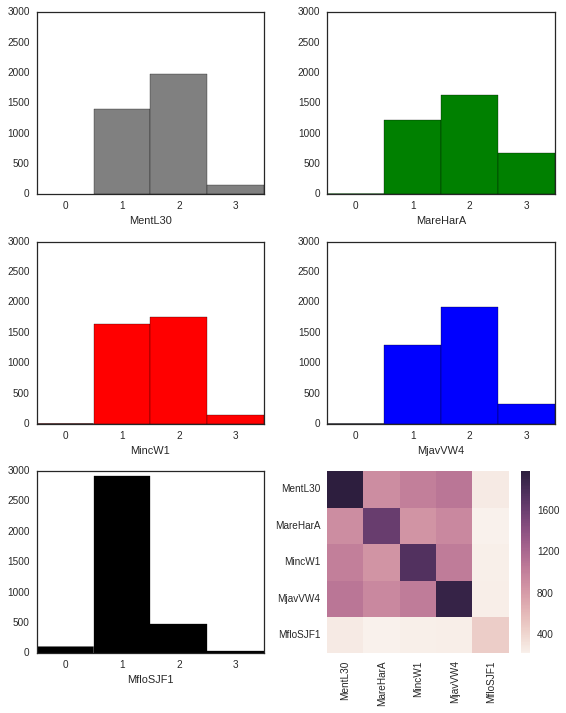

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("white")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,10), dpi=600)

c={'MincW1':'r','MjavVW4':'b','MentL30':'gray','MareHarA':'g','MfloSJF1':'black'}

i = [0,0,0,1,1,0,1,1,2,0,2,1]
for sp in ['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1']:
    g = sns.distplot(df[sp], kde=False,bins=[0,1,2,3,4],
                     ax=axes[i.pop(0)][i.pop(0)],
                     color=c[sp], hist_kws={'alpha': 1})
    g.set_xticklabels(['','0','','1','','2','','3',''])
    g.set_ylim(0,3000)
g = sns.heatmap(heatmap_df)
plt.tight_layout()
plt.savefig('./orthofinder/all_inputs/Results_Jan16/copy_numbers.png') 
 

# Figure S

In [136]:
heatmp_dict = {}

samples = ['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1']

for ind, row in df.iterrows():
    for i in range(len(samples)):
        for j in range(len(samples)):
            smp1 = samples[i]
            smp2 = samples[j]
            if row[smp1] == row[smp2] == 1:
                try:
                    heatmp_dict[smp1][smp2] += 1
                except:
                    try:
                        heatmp_dict[smp1][smp2] = 1
                    except:
                        heatmp_dict[smp1] = {smp2: 1}
                        
heatmap_df0 = pd.DataFrame.from_dict(heatmp_dict)
heatmap_df0 = heatmap_df0.reindex(['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1'])
heatmap_df0 = heatmap_df0[['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1']]

heatmp_dict = {}

samples = ['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1']

for ind, row in df.iterrows():
    for i in range(len(samples)):
        for j in range(len(samples)):
            smp1 = samples[i]
            smp2 = samples[j]
            if row[smp1] == row[smp2] == 3:
                try:
                    heatmp_dict[smp1][smp2] += 1
                except:
                    try:
                        heatmp_dict[smp1][smp2] = 1
                    except:
                        heatmp_dict[smp1] = {smp2: 1}
                        
heatmap_df1 = pd.DataFrame.from_dict(heatmp_dict)
heatmap_df1 = heatmap_df1.reindex(['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1'])
heatmap_df1 = heatmap_df1[['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1']]

heatmp_dict = {}

samples = ['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1']

for ind, row in df.iterrows():
    for i in range(len(samples)):
        for j in range(len(samples)):
            smp1 = samples[i]
            smp2 = samples[j]
            if row[smp1] == row[smp2] == 4:
                try:
                    heatmp_dict[smp1][smp2] += 1
                except:
                    try:
                        heatmp_dict[smp1][smp2] = 1
                    except:
                        heatmp_dict[smp1] = {smp2: 1}
                        
heatmap_df2 = pd.DataFrame.from_dict(heatmp_dict)
heatmap_df2 = heatmap_df2.reindex(['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1'])
heatmap_df2 = heatmap_df2[['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1']]

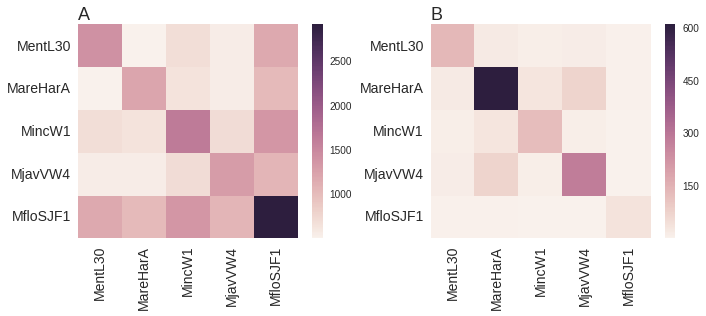

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("white")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5), dpi=600)

i = [0,1,2]


g = sns.heatmap(heatmap_df0.fillna(0),ax=axes[i.pop(0)])
g.set_xticklabels(['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1'],rotation=90, size=14) 
g.set_yticklabels(['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1'][::-1],rotation=0, size=14) 
g.set_title('A', loc='left',size=18)
plt.tight_layout()
g = sns.heatmap(heatmap_df1.fillna(0),ax=axes[i.pop(0)])
g.set_xticklabels(['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1'],rotation=90, size=14) 
g.set_yticklabels(['MentL30','MareHarA', 'MincW1','MjavVW4','MfloSJF1'][::-1],rotation=0, size=14) 
g.set_title('B', loc='left',size=18)
plt.tight_layout()
    
plt.savefig('./orthofinder/all_inputs/Results_Jan16/copy_numbers_sup.png') 